<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [3.5 Proportional (P) and Proportional-Integral (PI) Control](https://jckantor.github.io/cbe30338-2021/03.05-Proportional-Integral-Control.html) | [Contents](toc.html) | [4.0 Process Analytics](https://jckantor.github.io/cbe30338-2021/04.00-Process-Analytics.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.06-Lab-Assignment-PID-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.06-Lab-Assignment-PID-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 3.6 Lab Assignment 3: Relay and PI Control

This lab assignment introduces the use of relay, proportional (P), and proportional-integral (PI) control for the Temperature Control Laboratory. In this assignment you will 

1. implement and test a relay control for the dual heater/sensor system
2. implement and test a proportional-integral (PI) control algorithm for a single heater/sensor

## 3.6.1 Exercise 1. Relay (or On-Off) control


Create a notebook to implement a relay control for the Temperature Control Lab subject the following requirements:

* Simultaneous control of sensor temperatures T1 and T2.
* Use a tolerance value $d$ of 0.5 deg C.
* Set the minimum and maximum values of the heater to 0 and 100%, respectively. lab.P1 and lab.P2 should be left at their default values.
* Show the results of an experiment in which the setpoints are adjusted as follows:
    * SP1 is initially ambient temperature. SP1 increases to 35 deg at time t=20 and remains constant.
    * SP2 is initially ambient temperature. SP2 increases linearly to 45 deg C beginning at t=120 with the transition complete at time t=220.
    * Run the experiment until you reach a steady oscillation about the final operating point, and for no shorter than  600 sec.
    
    
Questions:

   1. After the system has settled to a steady oscillation about the final operating point, what is the maximum deviation from the setpoints?
   2. What is the approximate switching frequency of the manipulated variables?

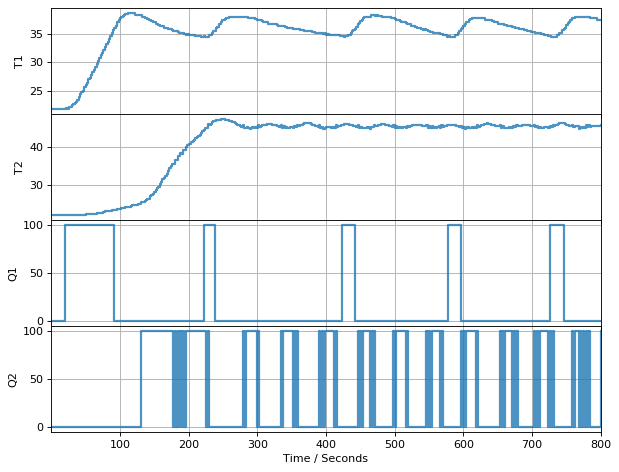

TCLab disconnected successfully.


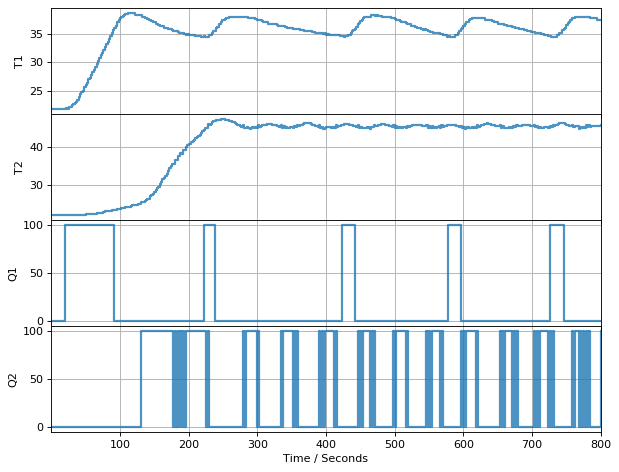

In [18]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

TCLab = setup(connected=True)

T_amb = 21 # deg. C.
Qmax = 100 # percent power
Qmin = 0 # percent power
tfinal = 800 # seconds
d = 0.5 # deg. C.

# Define a function to create the setpoints
def set_point(t,T_amb):        
    # set SP1
    if t < 20:
        SP1 = T_amb
    elif t >= 20:
        SP1 = 35
    # Set SP2
    if t < 120:
        SP2 = T_amb
    elif t >= 120 and t < 220:
        SP2 = 0.23*t - 5.6 # created a linear equation for SP2 increase
    else: 
        SP2 = 45
    return SP1,SP2

with TCLab() as lab:
    h = Historian(lab.sources)
    p = Plotter(h,tfinal)
    
    # lab P1 and P2 set at their default values
    
    # set initial manipulated variable values
    MV1 = 0
    MV2 = 0

    for t in clock(tfinal):
        # Set the process variables (PV's)
        PV1=lab.T1
        PV2=lab.T2
        
        # set the power
        # NOTE: I did not leave P1 and P2 at their default values - instead I increased them in order for the temperatures T1 and T2 to better
        # reach the setpoint values (SP1 and SP2) in the appropriate time. 
        lab.P1=200
        lab.P2=200
        
        # Set SP values
        SP1,SP2 = set_point(t,T_amb)
        
        # Set MV1
        if PV1 > SP1 + d:
            MV1 = Qmin
        elif PV1 <= SP1 - d:
            MV1 = Qmax
            
        lab.Q1(MV1)
        # Set MV2
        if PV2 > SP2 + d:
            MV2 = Qmin
        elif PV2 <= SP2 + d:
            MV2 = Qmax
        
        lab.Q2(MV2)
        
        p.update(t)
        
        

In [ ]:
# Questions:

# 1. After the system has settled to a steady oscillation about the final operating point, what is the maximum deviation from the setpoints?

# For T1, after the system settled to a steady oscillation about the final operating point of 35 deg. C., the maximum deviation from the setpoint
# was an approximate value of 4 degrees above the operating point.

# For T2, after the system settled to a steady oscillation about the final operating point of 45 deg. C., there were only slight deviations from the 
# setpoint (with very small oscillations). The maximum deviation from the setpoint is approximately 0.5 deg. C.

# 2. What is the approximate switching frequency of the manipulated variables?

# The approximate switching frequency for the first manipulated variable (MV1=Q1) - the first heater - after the system settled to a steady oscillation about the 
# final operating point was approximately 0.00667 / second (i.e. there were four switches from Qmin to Qmax within a 600 second timeframe)

# The approximate switching frequency for the second manipulated variable (MV2=Q2) - the second heater - 
# is not distinguishable because there were too many switches in short periods of time, possibly due to noise in the data.

## 3.6.2 Exercise 2. Implementing a PI Controller

Create a notebook to implement PI for the Temperature Control Lab.

* Using the simulation mode, create an implementaton of PI control and, by trail and error, find values for Kp and Ki, that provide a fast and accurate acquisition of the desired setpoint.

* Show the results of an experiment in which the setpoints are adjusted as follows:
    * SP1 is initially ambient temperature. SP1 increases linearly to 45 deg C beginning at t=20 with the transition complete at time t=120.
    * Run the experiment until you reach a steady oscillation about the final operating point, and for no shorter than  600 sec.
    
    
Questions:

   1. After the system has settled to a steady oscillation about the final operating point, what is the maximum deviation from the setpoints?


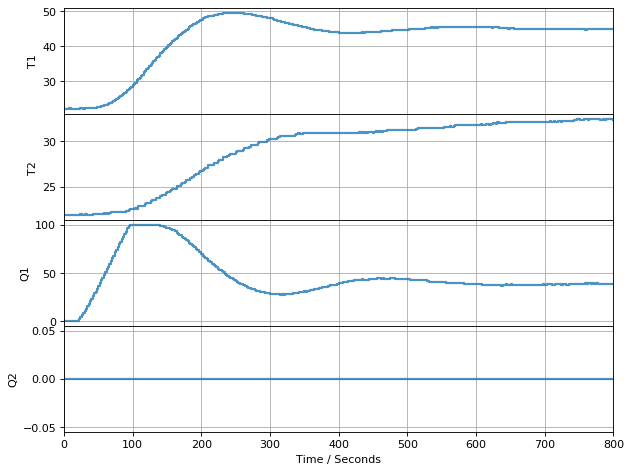

TCLab disconnected successfully.


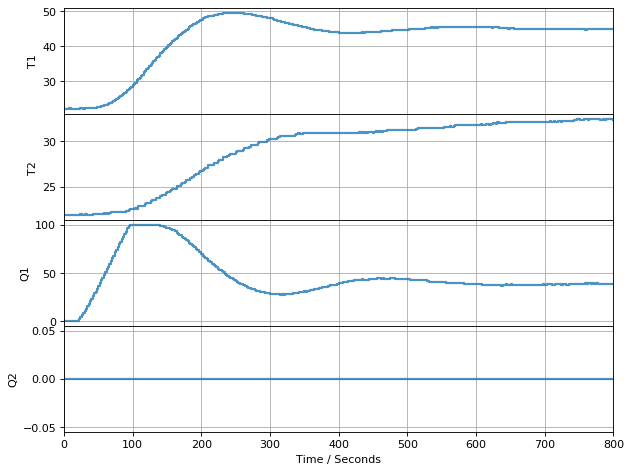

In [20]:
%matplotlib inline
from tclab import TCLab, clock, Historian, Plotter, setup

TCLab = setup(connected=True)

# set up the proportional integration function
def PI(Kp, Ki, MV_min, MV_max):
    MV = MV_min
    e_prev = 0
    while True:
        PV, SP = yield MV
        e = SP - PV
        MV = MV + Kp*(e - e_prev) + Ki*e
        MV = max(MV_min, min(MV_max, MV))
        e_prev = e

# control parameters
controller = PI(4, 0.2, MV_min=0, MV_max=100)
controller.send(None)

# Set parameter
T_amb = 22

# Define a function to create the setpoints
def set_point(t,T_amb):
    # set SP1
    if t < 20:
        SP1 = T_amb
    elif t >= 20 and t < 120:
        slope = (45-T_amb)/(120-20)
        intercept = 45-120*slope
        SP1 = slope*t+intercept
    elif t >= 120:
        SP1 = 45
    return SP1

# time horizon and time step
t_final = 800

# perform experiment
with TCLab() as lab:
    lab.P1 = 200
    h = Historian(lab.sources)
    p = Plotter(h, t_final)
    for t in clock(t_final):
        SP1 = set_point(t,T_amb)
        T1 = lab.T1
        U1 = controller.send((T1, SP1))
        lab.Q1(U1)
        p.update(t)    
        
h.to_csv('lab3_data.csv')

In [ ]:
# Question

# 1. After the system has settled to a steady oscillation about the final operating point, what is the maximum deviation from the setpoints?

# After the system settled to a steady oscillation about the final operating point of 45 deg. C. for T1, the maximum deviation was small. The oscillations
# had very small amplitudes, giving a maximum deviation of less than one degree C. This shows that the method of implementing a PI controller is effective
# in decreasing deviations from a fixed setpoint.

<!--NAVIGATION-->
< [3.5 Proportional (P) and Proportional-Integral (PI) Control](https://jckantor.github.io/cbe30338-2021/03.05-Proportional-Integral-Control.html) | [Contents](toc.html) | [4.0 Process Analytics](https://jckantor.github.io/cbe30338-2021/04.00-Process-Analytics.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/03.06-Lab-Assignment-PID-Control.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/03.06-Lab-Assignment-PID-Control.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>